# Computing the fractionation factors and the Michaelis-Menten fit of the DMSP-degrading enzymes from experimental data

In [1]:
# For numerical calculations
import numpy as np
import pandas as pd
import scipy as sp
import math
import matplotlib.animation as animation
from scipy.integrate import odeint
from numpy import arange
from pylab import *
from scipy.integrate import odeint
import scipy.optimize 
from scipy.optimize import leastsq
from math import exp
from collections import OrderedDict
from sklearn.linear_model import LinearRegression
pd.options.mode.chained_assignment = None
import git

# Find home directory for repo
repo = git.Repo("./", search_parent_directories=True)
homedir = repo.working_dir

# Import plotting features
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set_style("ticks")
sns.set_palette("colorblind", color_codes=True)
sns.set_context("paper")

# Magic command to plot inline
%matplotlib inline

#To graph in SVG (high def)
%config InlineBackend.figure_format="svg"

We will be using the data for DddP to exemplify the corrections made to the EA S isotope data. These include the following:

- Blank corrections, which aim at removing noise from the tin capsule that is used for the EA measurements (which may have traces of S that could contaminate the S isotope measurements of the sample)
- Linearity corrections, which take into account measurements of the $\delta ^{34}S$ of different amounts of reference gas to determine how much the amount of S causes a drift in the $\delta ^{34}S$ values.
- Standard corrections, which take into account the fact that the instrument has an associated intrinsic mass fractionation. We measured the  $\delta ^{34}S$ of two in house standards, sulfanilamide and seawater, from which we know the true $\delta ^{34}S$ interspersed with samples throught the EA-IRMS run, to determine how much the $\delta ^{34}S$ values measured in the samples might be deviated from their true values.

Let's start by loading the data:

In [2]:
# Import table with data
df_data =  pd.read_csv (f'{homedir}/data/raw/EA/20191008_EA.csv')

# Keep only rows with Peak Nr=2, since Peak Nr=1 
# and Peak Nr=3 correspond to the reference gas
#Select rows to drop
i1 = df_data[df_data['Peak_Nr'] == 1].index
i3 = df_data[df_data['Peak_Nr'] == 3].index
#Drop rows in place
df_data.drop(i1, inplace=True)
df_data.drop(i3, inplace=True)
df_data.head()

,Identifier,Amount,Time_min,Replicate,Peak_Nr,Area_All,Area_64,Area_66,Ampl_64,Ampl_66,d34S,Type
1,Sulfanilamide,4.0,NaN,NaN,2,43.939,41.922,2.018,1075,5164,2.064,Standard
4,SW,4.0,NaN,NaN,2,33.513,31.952,1.561,820,4003,18.531,Standard
7,DddP,NaN,3.0,a,2,43.982,41.951,2.031,1000,4830,10.342,Sample
10,DddP,NaN,3.0,b,2,57.127,54.490,2.637,1253,6052,9.735,Sample
13,DddP,NaN,3.0,c,2,68.432,65.272,3.160,1448,6998,10.388,Sample


Then, let's load the data for the blanks:

In [3]:
# Import table with the raw data for blanks
df_blanks = pd.read_csv(f'{homedir}/data/raw/EA/20191008_blanks.csv')

# Remove rows with missing data
df_blanks.dropna(how='any', inplace=True)

# Keep only rows with Peak Nr=2
#Select rows to drop
i1 = df_blanks[df_blanks['Peak_Nr'] == 1].index
i3 = df_blanks[df_blanks['Peak_Nr'] == 3].index
#Drop rows in place
df_blanks.drop(i1, inplace=True)
df_blanks.drop(i3, inplace=True)
df_blanks.head()

,Identifier 1,Peak_Nr,Area_All,Area_64,Area_66,Ampl_64,Ampl_66,d34S
1,Blank,2,1.741,1.661,0.080,42,203,4.682
4,Blank,2,1.764,1.683,0.081,43,209,4.419
7,Blank,2,2.498,2.383,0.115,61,296,5.850
10,Blank,2,2.087,1.991,0.096,52,250,5.467
13,Blank,2,1.923,1.835,0.088,48,233,5.040


Finally, let's load the data for the linearity test at the beginning of the run:

In [4]:
# Import linearity data
df_lin =  pd.read_csv(f'{homedir}/data/raw/EA/20191008_linearity.csv')
df_lin.head()

,Identifier,Peak_Nr,Area_All,Area_64,Area_66,Ampl_64,Ampl_66,d34S
0,linearity,1,13.245,12.637,0.607,655,3146,-0.087
1,linearity,2,36.455,34.783,1.672,1787,8590,0.000
2,linearity,3,50.341,48.032,2.309,2469,11867,-0.034
3,linearity,4,67.828,64.717,3.111,3324,15976,0.003
4,linearity,5,82.507,78.723,3.784,4034,19390,-0.016


The amount columns in the dataframes above correspond to the approximate amount of S in the standards in $\mu g$. Now, let's implement the corrections.
## Blank correction

In [5]:
# Get the average area all for the blanks
blank_area_all_average = df_blanks["Area_All"].mean()

# Get the average d34S for the blanks
blank_d34s_average = df_blanks["d34S"].mean()

# Append a column to the data dataframe with the 
# correction of area by blank: substraction of the
# area of the measurement by the area of the blank

df_data['Correction_of_area_blank'] = \
    np.subtract(df_data['Area_All'], blank_area_all_average)

# Correction of d34S by blank: 
    
# Get the product of the d34S by the area of each measurement
num1 = np.multiply (df_data['d34S'], df_data['Area_All'])
# Get the product of the d34S by the area of the average of the blanks
num2 = blank_d34s_average * blank_area_all_average  
#Subtract the product of d34S by the product of the blanks
num = np.subtract (num1, num2)
#Divide by the area corrected by blank and
#append column to the data dataframe
df_data['Correction_of_d34S_blank'] = \
    np.divide (num, df_data['Correction_of_area_blank'])

## Linearity correction

In [6]:
# Create variables for linear regression
# x will be the amplitude of the peak of mass 64 = ^32S + ^16O + ^16O
# We divided by 1000 to convert volts ot milivolts
x = (df_lin['Ampl_64'].values/1000).reshape((-1,1))
# y will be the values of d34S
y = (df_lin['d34S'])

# Create model of linear regression
model = LinearRegression().fit(x,y)

#Determine R square, intercept and slope
r_sq = model.score(x,y)
intercept = model.intercept_
s = model.coef_
slope=s[0]

# Calculate an amplitude difference by centering around an arbitrary 
# value in the Ampl_64 column of the data dataframe  
num= np.subtract(df_data['Ampl_64'], 1100)
ampl_difference = np.divide (num, 1000)

# Calculate the amplitude correction factor
ampl_correction_factor = (slope * ampl_difference)+intercept

# Correct the d34S corrected by amplitude by
# subtracting the blank corrected data by the amplitude correction
# factor and append the column to the data dataframe
df_data['Correction_of_d34S_by_amplitude'] = \
    np.subtract(df_data['Correction_of_d34S_blank'], ampl_correction_factor)

## Standard correction 

First, let's create a category column in the dataframe according to the size of the area of the peak of each sample and standard.

In [7]:
# Correct each sample by standards with similar areas

#Create standard correction group empty list
Std_group = []
# Classify the area of the samples by category 
# Loop through dataframe rows
for row in df_data['Area_All']:
    if row <= 50:
        Std_group.append ('low')
    elif row >= 50.1:
        Std_group.append ('high')        
# Append to data dataframe 
df_data['Std_group'] = Std_group
df_data.head()

df_data.head()

,Identifier,Amount,Time_min,Replicate,Peak_Nr,Area_All,Area_64,Area_66,Ampl_64,Ampl_66,d34S,Type,Correction_of_area_blank,Correction_of_d34S_blank,Correction_of_d34S_by_amplitude,Std_group
1,Sulfanilamide,4.0,NaN,NaN,2,43.939,41.922,2.018,1075,5164,2.064,Standard,41.9364,1.919422,1.995422,low
4,SW,4.0,NaN,NaN,2,33.513,31.952,1.561,820,4003,18.531,Standard,31.5104,19.385123,19.466531,low
7,DddP,NaN,3.0,a,2,43.982,41.951,2.031,1000,4830,10.342,Sample,41.9794,10.592467,10.670057,low
10,DddP,NaN,3.0,b,2,57.127,54.490,2.637,1253,6052,9.735,Sample,55.1244,9.903689,9.975913,high
13,DddP,NaN,3.0,c,2,68.432,65.272,3.160,1448,6998,10.388,Sample,66.4294,10.547667,10.615754,high


Then, let's create a dataframe for standards only where we append their true values and ditch the outliers.

In [8]:
# Create df with only standard data
df_standards = df_data[(df_data.Type == 'Standard')] 
#Sort values by ID and area
df_standards = df_standards.sort_values(['Identifier', 'Area_All'])

#Drop outliers in place
df_standards.drop(df_standards.index[10], inplace=True)
df_standards.drop(df_standards.index[0], inplace=True)

# Calculate the slope and intercept for calculated vs. true value of the stds

# Append true value column to the standard table
# For sulfanilamide
df_standards.loc[df_standards['Identifier'] \
                  == 'Sulfanilamide', 'True_d34S'] = 2.42
# For seawater
df_standards.loc[df_standards['Identifier'] \
                  == 'SW', 'True_d34S'] = 21
                       
# Group by Std_group
df_stdgroup = df_standards.groupby (['Std_group'])

df_standards.head()

,Identifier,Amount,Time_min,Replicate,Peak_Nr,Area_All,Area_64,Area_66,Ampl_64,Ampl_66,d34S,Type,Correction_of_area_blank,Correction_of_d34S_blank,Correction_of_d34S_by_amplitude,Std_group,True_d34S
4,SW,4.0,NaN,NaN,2,33.513,31.952,1.561,820,4003,18.531,Standard,31.5104,19.385123,19.466531,low,21.0
130,SW,4.0,NaN,NaN,2,43.889,41.844,2.045,1093,5332,19.420,Standard,41.8864,20.105045,20.180662,low,21.0
43,SW,4.0,NaN,NaN,2,43.915,41.868,2.047,1046,5107,19.584,Standard,41.9124,20.276456,20.353070,low,21.0
91,SW,4.0,NaN,NaN,2,44.516,42.441,2.076,1063,5193,19.581,Standard,42.5134,20.263525,20.339779,low,21.0
49,SW,6.0,NaN,NaN,2,65.551,62.495,3.056,1595,7788,19.857,Standard,63.5484,20.322302,20.387271,high,21.0


Below, we make a linear regression for the standards of each area group.

In [9]:
# Get the slope and intercept for the standards of each group
# Define column names
names = ['Std_group', 'R squared', 'Intercept', 'Slope']

# Initialize empty dataframe to save fit results
df_linreg_stds = pd.DataFrame(columns=names)
                 
# Create variables for linear regression
#Loop through standard groups                       
for group, data in enumerate (df_stdgroup):
    #x will be the values of d34S of the stds corrected by blanks and linearity
    x_std = data[1].Correction_of_d34S_by_amplitude.values.reshape((-1,1))
    #y will be the true values of d34S of each standard
    y_std = data[1].True_d34S
    # Create model
    model = LinearRegression().fit(x_std,y_std)
    #Determine R square, intercept and slope
    r_sq_stds = model.score(x_std,y_std)
    intercept_stds = model.intercept_
    s1 = model.coef_
    slope_stds = s1[0]
    # Store parameters and group as list
    params = (data[1].Std_group.unique(), r_sq_stds, intercept_stds, slope_stds)
 
    # Convert list to pandas Series
    series = pd.Series(params, index=names)   
    # Append parameters to dataframe
    df_linreg_stds = df_linreg_stds.append(series, ignore_index=True)
#Round the values of the dataframe to two decimal places
df_linreg_stds = df_linreg_stds.round(2)     
df_linreg_stds 

,Std_group,R squared,Intercept,Slope
0,[high],1.0,0.53,1.01
1,[low],1.0,-0.47,1.07


Finally, let's apply the standard correction to the samples based on their area:

In [12]:
#Apply corrections by true value and area

# Initialize lists to save values
slopes = []
intercepts = []
Correction_of_d34S_by_true_value = []

#loop through rows in dataframe
for index, row in df_data.iterrows():
    # Extract standard group
    Std_group = row.Std_group
    # Extract slope and intercept
    slope = df_linreg_stds[df_linreg_stds.Std_group == Std_group].Slope.iloc[0]
    intercept = df_linreg_stds[df_linreg_stds.Std_group == Std_group].Intercept.iloc[0]
    slopes.append(slope)
    intercepts.append(intercept)
    # Compute corrected concentration
    Correction_of_d34S_by_true_value.append(intercept + slope * row.Correction_of_d34S_by_amplitude)
    
# Append values to dataframe
df_data['Correction_of_d34S_by_true_value'] = Correction_of_d34S_by_true_value

df_data.head()

,Identifier,Amount,Time_min,Replicate,Peak_Nr,Area_All,Area_64,Area_66,Ampl_64,Ampl_66,d34S,Type,Correction_of_area_blank,Correction_of_d34S_blank,Correction_of_d34S_by_amplitude,Std_group,Correction_of_d34S_by_true_value
1,Sulfanilamide,4.0,NaN,NaN,2,43.939,41.922,2.018,1075,5164,2.064,Standard,41.9364,1.919422,1.995422,low,1.665101
4,SW,4.0,NaN,NaN,2,33.513,31.952,1.561,820,4003,18.531,Standard,31.5104,19.385123,19.466531,low,20.359188
7,DddP,NaN,3.0,a,2,43.982,41.951,2.031,1000,4830,10.342,Sample,41.9794,10.592467,10.670057,low,10.946961
10,DddP,NaN,3.0,b,2,57.127,54.490,2.637,1253,6052,9.735,Sample,55.1244,9.903689,9.975913,high,10.605672
13,DddP,NaN,3.0,c,2,68.432,65.272,3.160,1448,6998,10.388,Sample,66.4294,10.547667,10.615754,high,11.251912


We were not able to measure the $\delta^{34}S$ value for the samples at time=0, cause the enzymes started acting upon addition to the reaction vials and filtering the cell lysate out of the reactions would take about 3 min. For this reason, we made a linear regression from the data to infer them.

In [13]:
# Create dataframe that included only data from the samples
df_samples = df_data[(df_data.Type == 'Sample')]

# Determine point 0 in d34s fom linear regression of the data

# Group data by ID and replicate
df_group = df_samples.groupby(['Identifier','Replicate'])

# Define column names
names = ['Identifier', 'Correction_of_d34S_by_true_value', 'r_sq']

# Initialize empty dataframe to save fit results
df_linreg_d34s = pd.DataFrame(columns=names)

# Create variables for linear regression
# Loop through grouped data
for i, (group, data) in enumerate (df_group):
    #x will be the time
    xi = (data['Time_min'].values).reshape((-1,1))
    #y will be the corrected d34S value
    yi = (data['Correction_of_d34S_by_true_value'])
    # Create model
    model = LinearRegression().fit(xi,yi)
    #Determine R squared and intercept 
    r_sq = model.score(xi,yi)
    intercept = model.intercept_
    # Store parameters and group as list
    params = (data.Identifier.unique()[0], intercept, r_sq)
    # Convert list to pandas Series
    series = pd.Series(params, index=names)   
    # Append parameters to dataframe
    df_linreg_d34s = df_linreg_d34s.append(series, ignore_index=True)
# Round the values in the dataframe to 2 decimal digits
df_linreg_d34s = df_linreg_d34s.round(2)  

#Add column with replicate and time to the linear reg. dataframe
df_linreg_d34s ['Time_min'] = (0,0,0,0,0,0)
df_linreg_d34s ['Replicate'] = ('a','b','c','a','b','c')
df_linreg_d34s ['Type'] = ('Sample','Sample','Sample','Sample','Sample','Sample')

#Append data of time 0 to the main dataframe
frames = [df_data, df_linreg_d34s]
df_data = pd.concat(frames, sort=False)
df_data.head()

# Create sample dataframe
df_samples = df_data[(df_data.Type == 'Sample')]

Since all the corrections have been done, we will now export the corrected data, which must be combined with the HPLC data to get the plots of DMSP degradation and change in the $\delta^{34}S$ of the remaining DMSP as a function of time or -ln of DMSP remaining.

In [17]:
# Export data table
df_samples.to_csv(f'{homedir}/data/processed/EA/20191008_EA.csv')

df_samples.head()

,Identifier,Amount,Time_min,Replicate,Peak_Nr,Area_All,Area_64,Area_66,Ampl_64,Ampl_66,d34S,Type,Correction_of_area_blank,Correction_of_d34S_blank,Correction_of_d34S_by_amplitude,Std_group,Correction_of_d34S_by_true_value,r_sq
7,DddP,NaN,3.0,a,2.0,43.982,41.951,2.031,1000.0,4830.0,10.342,Sample,41.9794,10.592467,10.670057,low,10.946961,NaN
10,DddP,NaN,3.0,b,2.0,57.127,54.490,2.637,1253.0,6052.0,9.735,Sample,55.1244,9.903689,9.975913,high,10.605672,NaN
13,DddP,NaN,3.0,c,2.0,68.432,65.272,3.160,1448.0,6998.0,10.388,Sample,66.4294,10.547667,10.615754,high,11.251912,NaN
16,DddP,NaN,15.0,a,2.0,54.798,52.267,2.531,1303.0,6300.0,9.594,Sample,52.7954,9.764782,9.835945,high,10.464305,NaN
19,DddP,NaN,15.0,b,2.0,76.759,73.213,3.546,1758.0,8501.0,9.464,Sample,74.7564,9.581129,9.642641,high,10.269068,NaN


### Analytical repeatability of measurements

Let's calculate the analytical repeatability of the EA-IRMS measurements. 

In [18]:
# Update standard df
# Create a dataframe for only standards from the updated data dataframe
df_standards = df_data[(df_data.Type == 'Standard')]
#Sort values
df_standards = df_standards.sort_values(['Identifier', 'Area_All'])


In [19]:
#Group standards by identifier and amount
grouped_standards = df_standards.groupby(['Identifier', 'Amount'])

# Determine the mean of each standard  and rename the series
mean_stds = grouped_standards['Correction_of_d34S_by_true_value'].mean()
mean_stds = mean_stds.rename("d34S_mean")

# Determine the standard deviation of each standard  and rename the series
std_dev_stds = grouped_standards['Correction_of_d34S_by_true_value'].std()
std_dev_stds = std_dev_stds.rename("d34S_stdev")

#Pass series to individual dataframes
df_mean_stds=mean_stds.to_frame()
df_std_dev_stds=std_dev_stds.to_frame()

#merge the mean and standard deviation dataframes
df_anrep = pd.merge(df_mean_stds, df_std_dev_stds,  how='outer', on=['Identifier', 'Amount'])

#Reset index of the dataframe
df_anrep = df_anrep.reset_index()

#Add column of true value of the standards
df_anrep.loc[df_anrep['Identifier'] \
                  == 'Sulfanilamide', 'True_d34S'] = 2.42
df_anrep.loc[df_anrep['Identifier'] \
                  == 'SW', 'True_d34S'] = 21

#Determine the accuracy by subtracting the true value from the average value of each standard
df_anrep ['Accuracy'] = abs(df_anrep ['True_d34S'] - df_anrep ['d34S_mean'])
df_anrep

,Identifier,Amount,d34S_mean,d34S_stdev,True_d34S,Accuracy
0,SW,2.0,21.232486,NaN,21.00,0.232486
1,SW,4.0,21.020961,0.449073,21.00,0.020961
2,SW,6.0,21.001431,0.169300,21.00,0.001431
3,Sulfanilamide,2.0,3.239242,NaN,2.42,0.819242
4,Sulfanilamide,4.0,2.054586,0.266657,2.42,0.365414
5,Sulfanilamide,6.0,2.420072,0.212671,2.42,0.000072


## Import the HPLC data and calculate the fraction of DMSP remaining

Let's begin by loading the HPLC data:

In [15]:
df_hplc = pd.read_csv(f'{homedir}/data/raw/HPLC/hplc_master_table_raw_100.csv')

# Add real concentration column to the hplc master table
#Create empty list
real_conc=[]
#loop through rows
for i, row in df_hplc.iterrows():
    # Add real concentration to empty list if it exists
    if math.isnan(row.Calc_conc):
        real_conc.append (row.Real_conc)
    # If ther real concentration does not exist, calculate it by multiplying by 10 
    #(1:10 dilution) the calculated concentration
    else:
        real_conc.append(row.Calc_conc*10)
    
df_hplc['Real_conc'] = real_conc
# Sort values
df_hplc = df_hplc.sort_values(['Name', 'Replicate', 'Time_min'])

df_hplc.tail()

,Name,Replicate,Time_min,Calc_conc,Real_conc,Date,Volume_rxn,Volume_capsule
91,DmdA,c,3,NaN,166.245308,20191001,360.0,24.796289
92,DmdA,c,15,NaN,159.307318,20191001,380.0,29.859299
93,DmdA,c,25,NaN,96.723331,20191001,360.0,34.014851
94,DmdA,c,38,NaN,86.495486,20191001,430.0,35.597964
95,DmdA,c,51,NaN,68.000000,20191001,580.0,21.092951


We will calculate the fraction of reactant remaining for each replicate at each time point:

In [16]:
#Create ID column with the combination of enzyme, time and replicate
df_hplc['ID'] = df_hplc['Name'] + '_' +\
df_hplc['Time_min'].astype(int).map(str) + '_' + \
df_hplc['Replicate'].map(str)

# Create new name_date column with the combination of enzyme and replicate
df_hplc['Name_Rep'] = df_hplc['Name'] + '_' +\
df_hplc['Replicate'].map(str)

# Get the max values for corrected concentration for each enzyme and replicate and 
# append it to a new column
df_hplc['Real_conc_max'] = \
df_hplc.groupby(['Name_Rep'])['Real_conc'].transform(max)

# Get the fraction of reactant remaining for each time point
df_hplc['f_R'] = abs(np.divide(df_hplc['Real_conc'], \
               df_hplc['Real_conc_max']))
df_hplc.head()

,Name,Replicate,Time_min,Calc_conc,Real_conc,Date,Volume_rxn,Volume_capsule,ID,Name_Rep,Real_conc_max,f_R
53,Alma1,a,0,8.204402,82.044021,20190913,NaN,NaN,Alma1_0_a,Alma1_a,82.044021,1.000000
52,Alma1,a,3,4.780346,47.803459,20190913,NaN,NaN,Alma1_3_a,Alma1_a,82.044021,0.582656
51,Alma1,a,8,3.125295,31.252950,20190913,NaN,NaN,Alma1_8_a,Alma1_a,82.044021,0.380929
50,Alma1,a,16,1.278266,12.782661,20190913,NaN,NaN,Alma1_16_a,Alma1_a,82.044021,0.155802
49,Alma1,a,21,1.183789,11.837885,20190913,NaN,NaN,Alma1_21_a,Alma1_a,82.044021,0.144287


In [17]:
# Export data table
df_hplc.to_csv(f'{homedir}/data/processed/HPLC/hplc_master_table_raw_100.csv')

### Analytical repeatability of measurements

Let's calculate the analytical repeatability of the HPLC measurements for the date corresponding to this enzyme measurements:

In [22]:
# Import table with the repeatability data
df_hplc_qc = pd.read_csv(f'{homedir}/data/raw/HPLC/hplc_qc.csv')

#Filter by date
df_enzyme_qc = df_hplc_qc.loc[lambda x: (x['Date'] == 20190901)]
# Calculate the mean and standard deviation                           
df_group_qc = df_enzyme_qc.groupby(['Date']).agg(
                      {'Calc_Conc':['mean','std']})

# Create a column for relative standard deviation
df_group_qc['rstdev'] = df_group_qc['Calc_Conc', 'std'] * 100 / df_group_qc['Calc_Conc', 'mean']
df_group_qc

Calc_Conc              rstdev
              mean       std          
Date                                  
20190901       9.7  0.160312  1.652703

## Create master table

Now, let's create a table to compile the corrected values from EA-IRMS and HPLC. We will begin by loading the processed EA data and dropping the non-needed columns:

In [51]:
# Import tables with the EA processed data
df_ea_1 = pd.read_csv(f'{homedir}/data/processed/EA/20191008_EA.csv')

# Create empty master dataframe
df_master=pd.DataFrame()

# Fill master table
df_master['Name'] = df_ea_1['Identifier']
df_master['d34S'] = df_ea_1['Correction_of_d34S_by_true_value']
df_master['Replicate'] = df_ea_1['Replicate']
df_master['Time_min'] = (df_ea_1['Time_min']).astype(int)

#Create new ID column with the combination of enzyme, time and date
df_master['ID'] = df_master['Name'] + '_' +\
df_master['Time_min'].map(str) + '_' + df_master['Replicate'].map(str)

# Sort values
df_master = df_master.sort_values(['Name', 'Replicate', 'Time_min'])
df_master.head()

,Name,d34S,Replicate,Time_min,ID
30,DddP,10.820000,a,0,DddP_0_a
0,DddP,10.946961,a,3,DddP_3_a
3,DddP,10.464305,a,15,DddP_15_a
6,DddP,10.620075,a,25,DddP_25_a
9,DddP,10.673636,a,38,DddP_38_a


Now, we will fuse this table with the HPLC table:

In [52]:
# Append f_r (fraction of DMSP remaining) column to the master table               
df_master = df_master.merge(df_hplc.filter(['ID', 'f_R']), how='left',
                 left_on='ID', right_on='ID') 

# Append corrected DMSP concentration column to the master table  
df_master = df_master.merge(df_hplc.filter(['ID', 'Real_conc']), \
                            how='left', left_on='ID', right_on='ID')  

# Append -ln(f_r) column to the master table
df_master['minus_ln_f_R'] = abs(-np.log(df_master['f_R']))

#Append 1000 × ln (1+δ34S/1000) -> approximation to get slope
# column to the master table
df_master['d34S_approx'] = 1000 * \
np.log(1+(df_master['d34S']/1000))

df_master.head()

,Name,d34S,Replicate,Time_min,ID,f_R,Real_conc,minus_ln_f_R,d34S_approx
0,DddP,10.820000,a,0,DddP_0_a,1.000000,207.193975,0.000000,10.761883
1,DddP,10.946961,a,3,DddP_3_a,0.861376,178.471949,0.149224,10.887477
2,DddP,10.464305,a,15,DddP_15_a,0.512602,106.208079,0.668255,10.409933
3,DddP,10.620075,a,25,DddP_25_a,0.468065,96.980176,0.759149,10.564078
4,DddP,10.673636,a,38,DddP_38_a,0.422335,87.505211,0.861957,10.617075


There is one correction still missing, which involves filtering out the $\delta^{34}S$ values of DMSP from the measured $\delta^{34}S$ values, which are a combination of those of DMSP and those of the cell lysate.

### Mixing model for Cell lysate and DMSP at t=0

The first step is to filter by enzyme. Then, we will calculate the isotopic ratios ($^{34}R$) and the fractional abundance ($^{34}F$) of S ($^{34}S/^{32}S$) in each measured timepoint from the $\delta^{34}S$ values of the mixture. This is required because the fractional abundances mix linearly, whereas the delta values do not.

In [25]:
# Filter by DddP 
df_dddp= df_master[(df_master.Name == 'DddP')]
df_dddp.head()

,Name,d34S,Replicate,Time_min,ID,f_R,Real_conc,minus_ln_f_R,d34S_approx
0,DddP,10.820000,a,0,DddP_0_a,1.000000,207.193975,0.000000,10.761883
1,DddP,10.946961,a,3,DddP_3_a,0.861376,178.471949,0.149224,10.887477
2,DddP,10.464305,a,15,DddP_15_a,0.512602,106.208079,0.668255,10.409933
3,DddP,10.620075,a,25,DddP_25_a,0.468065,96.980176,0.759149,10.564078
4,DddP,10.673636,a,38,DddP_38_a,0.422335,87.505211,0.861957,10.617075


#### Conversion of delta values to isotopic ratios

$$
^{34}R(mix)_{0} = (\delta ^{34}S(mix)_{0} + 1) \cdot ^{34}R_{VCTD}
\tag{1}
$$

$$
^{34}R_{VCTD} = 45004.5 ± 9.3
$$

In [26]:
#Conversion of delta values to isotopic ratios

df_dddp['r34_approx'] = ((df_dddp['d34S_approx']/1000)+1)*0.0450045
df_dddp.head()

,Name,d34S,Replicate,Time_min,ID,f_R,Real_conc,minus_ln_f_R,d34S_approx,r34_approx
0,DddP,10.820000,a,0,DddP_0_a,1.000000,207.193975,0.000000,10.761883,0.045489
1,DddP,10.946961,a,3,DddP_3_a,0.861376,178.471949,0.149224,10.887477,0.045494
2,DddP,10.464305,a,15,DddP_15_a,0.512602,106.208079,0.668255,10.409933,0.045473
3,DddP,10.620075,a,25,DddP_25_a,0.468065,96.980176,0.759149,10.564078,0.045480
4,DddP,10.673636,a,38,DddP_38_a,0.422335,87.505211,0.861957,10.617075,0.045482


#### Conversion of isotopic ratios to fractional abundances

$$
^{34}F(mix)_{0} = {^{34}R(mix)_{0} \over 1 + ^{34}R(mix)_{0}}
\tag{2}
$$


In [27]:
#Conversion of isotopic ratios to fractional abundances

df_dddp['f34_approx'] = df_dddp['r34_approx']/(1+df_dddp['r34_approx'])
df_dddp.head()

,Name,d34S,Replicate,Time_min,ID,f_R,Real_conc,minus_ln_f_R,d34S_approx,r34_approx,f34_approx
0,DddP,10.820000,a,0,DddP_0_a,1.000000,207.193975,0.000000,10.761883,0.045489,0.043510
1,DddP,10.946961,a,3,DddP_3_a,0.861376,178.471949,0.149224,10.887477,0.045494,0.043515
2,DddP,10.464305,a,15,DddP_15_a,0.512602,106.208079,0.668255,10.409933,0.045473,0.043495
3,DddP,10.620075,a,25,DddP_25_a,0.468065,96.980176,0.759149,10.564078,0.045480,0.043501
4,DddP,10.673636,a,38,DddP_38_a,0.422335,87.505211,0.861957,10.617075,0.045482,0.043504


Now, we will utilize the following mixing calculation:

$$
^{34}F(mix)_{0} = {[DMSP]_0 \cdot ^{34}F_{DMSP\;0} + [S\hspace{1mm}in\hspace{1mm}cell\hspace{1mm}lysate] \cdot ^{34}F_{S\hspace{1mm}in\hspace{1mm}cell\hspace{1mm}lysate} \over [DMPS]_0  +
[S\hspace{1mm}in\hspace{1mm}cell\hspace{1mm}lysate]}
\tag{3}
$$

In this equation, $^{34}F(mix)_{0}$ is the fractional abundance of S ($^{34}S/^{32}S$) at time=0 in the reaction vial, which relates to the isotopic ratio ($^{34}R$) and the $\delta^{34}S$ by means of the Equations 1 and 2. $[DMSP]_0$ and $[S\hspace{1mm}in\hspace{1mm}cell\hspace{1mm}lysate]$ are the concentrations of DMSP and S in the cell lysate at t =0, respectively. $^{34}F_{DMSP\;0}$ and $^{34}F_{S\hspace{1mm}in\hspace{1mm}cell\hspace{1mm}lysate}$ are the fractional abundances of S ($^{34}S/^{32}S$) in DMSP and the cell lysate at t=0, respectively. 

Reorganizing Eq. 3, we get:

$$
[S\hspace{1mm}in\hspace{1mm}cell\hspace{1mm}lysate] = [DMPS]_0 {(^{34}F_{DMSP\;0} - ^{34}F(mix)_{0}) \over
(^{34}F_{DMSP\;0} - ^{34}F_{S\hspace{1mm}in\hspace{1mm}cell\hspace{1mm}lysate})}
$$

Before calculating the concentration of S in the cell lysate at t=0, we need to create a dataframe with the true values of $\delta^{34}S$ of DMSP before any degradation happened, and those of the cell lysate.

In [28]:
#Create dataframe with true values for cell lysate and DMSP

# List of true values
dmsp_tv = [14.402934, 14.318284, 14.264486]
cell_lysate_tv = [7.765655, 7.971817, 8.227773] 
  
# Dictionary of lists  
dict_tv = {'d34S_dmsp': dmsp_tv, 'd34S_cell_lysate': cell_lysate_tv}  

#Send dictionary to dataframe
df_tv = pd.DataFrame(dict_tv) 
    
df_tv

,d34S_dmsp,d34S_cell_lysate
0,14.402934,7.765655
1,14.318284,7.971817
2,14.264486,8.227773


Now, we will convert these delta values to isotopic ratios and fractional abundances:

In [53]:
#Conversion of delta values to isotopic ratios
df_tv['r34_dmsp'] = ((df_tv['d34S_dmsp']/1000)+1)*0.0450045
df_tv['r34_cell_lysate'] = ((df_tv['d34S_cell_lysate']/1000)+1)*0.0450045

#Conversion of isotopic ratios to fractional abundances
df_tv['f34_dmsp'] = df_tv['r34_dmsp']/(1+df_tv['r34_dmsp'])
df_tv['f34_cell_lysate'] = df_tv['r34_cell_lysate']/(1+df_tv['r34_cell_lysate'])

Now, let's find the concentration of S in the cell lysate:

In [30]:
# Filter by dddp at t=0
df_dddp_t_0= df_dddp[(df_dddp.Time_min == 0)]
df_dddp_t_0

#Calculation of average values of 34_F
f34_dmsp = df_tv['f34_dmsp'].mean()
f34_cell_lysate = df_tv['f34_cell_lysate'].mean()
f34_mix_0 = df_dddp_t_0['f34_approx'].mean()

#Calculation of the concentration of S in the cell lysate in micromolar

#Define empty list
conc_s_cell_lysate= []
# Loop through the concentrations of DMSP at t=0
for i in df_dddp_t_0.Real_conc:
    #Get the concentration of s at t=0 from Eq. 3
    s = i * (f34_dmsp - f34_mix_0)/(f34_mix_0-f34_cell_lysate)
    #Append to list
    conc_s_cell_lysate.append(s)
#Append list to dataframe
df_dddp_t_0['conc_s_cell_lysate']=conc_s_cell_lysate
df_dddp_t_0

,Name,d34S,Replicate,Time_min,ID,f_R,Real_conc,minus_ln_f_R,d34S_approx,r34_approx,f34_approx,conc_s_cell_lysate
0,DddP,10.82,a,0,DddP_0_a,1.0,207.193975,0.0,10.761883,0.045489,0.043510,263.586963
6,DddP,10.52,b,0,DddP_0_b,1.0,202.639093,0.0,10.465050,0.045475,0.043497,257.792356
12,DddP,11.17,c,0,DddP_0_c,1.0,200.075625,0.0,11.108076,0.045504,0.043524,254.531176


In [31]:
#Create dataframe just for conc of S in cell lysate in each replicate
df_s_cell_lysate = df_dddp_t_0[['Replicate', 'conc_s_cell_lysate']]
df_s_cell_lysate

,Replicate,conc_s_cell_lysate
0,a,263.586963
6,b,257.792356
12,c,254.531176


In [32]:
# Append the concentration of S in cell lysate to the main enzyme dataframe
# for each replicate 
                 
df_dddp = pd.merge(df_dddp, df_s_cell_lysate,  how='inner', on=['Replicate'], suffixes=('', '_y'))
df_dddp.head()

,Name,d34S,Replicate,Time_min,ID,f_R,Real_conc,minus_ln_f_R,d34S_approx,r34_approx,f34_approx,conc_s_cell_lysate
0,DddP,10.820000,a,0,DddP_0_a,1.000000,207.193975,0.000000,10.761883,0.045489,0.043510,263.586963
1,DddP,10.946961,a,3,DddP_3_a,0.861376,178.471949,0.149224,10.887477,0.045494,0.043515,263.586963
2,DddP,10.464305,a,15,DddP_15_a,0.512602,106.208079,0.668255,10.409933,0.045473,0.043495,263.586963
3,DddP,10.620075,a,25,DddP_25_a,0.468065,96.980176,0.759149,10.564078,0.045480,0.043501,263.586963
4,DddP,10.673636,a,38,DddP_38_a,0.422335,87.505211,0.861957,10.617075,0.045482,0.043504,263.586963


Now that we have determined the concentration of S in the cell lysate for each replicate, we can calculate the $\delta^{34}S$ of DMSP in the measurements from the $^{34}F$ of the measurement (mixture of DMSP and cell lysate).

### Calculation of $\delta^{34}S$ of DMSP by correcting the $^{34}F_{mix}$

Reorganizing a generalized form of Eq. 3, we get that:

$$
^{34}F_{DMSP} = {[S\hspace{1mm}in\hspace{1mm}cell\hspace{1mm}lysate] 
(^{34}F(mix)-^{34}F_{S\hspace{1mm}in\hspace{1mm}cell\hspace{1mm}lysate})
+ [DMSP]\cdot ^{34}F(mix) \over [DMPS]},  
$$ 

where $^{34}F(mix)$ is the fractional abundance of S ($^{34}S/^{32}S$) at any timepoint in the reaction vial, which relates to the isotopic ratio ($^{34}R$) and the $\delta^{34}S$ by means of the Equations 1 and 2. [DMSP] and $[S\hspace{1mm}in\hspace{1mm}cell\hspace{1mm}lysate]$ are the concentrations of DMSP and S in the cell lysate at any of the measured timepoints, respectively. $^{34}F_{DMSP}$ and $^{34}F_{S\hspace{1mm}in\hspace{1mm}cell\hspace{1mm}lysate}$ are the fractional abundances of S ($^{34}S/^{32}S$) in DMSP and the cell lysate at any of the measured timepoints, respectively. 

In [33]:
#Calculation of 34_F_DMSP
# Append column to the enzyme dataframe with the app. value of ^34F_DMSP
df_dddp['F34_approx_DMSP']= ((df_dddp['conc_s_cell_lysate'] * (df_dddp['f34_approx']-f34_cell_lysate))+ 
                             (df_dddp['Real_conc']*df_dddp['f34_approx']))/df_dddp['Real_conc']
df_dddp.head()

,Name,d34S,Replicate,Time_min,ID,f_R,Real_conc,minus_ln_f_R,d34S_approx,r34_approx,f34_approx,conc_s_cell_lysate,F34_approx_DMSP
0,DddP,10.820000,a,0,DddP_0_a,1.000000,207.193975,0.000000,10.761883,0.045489,0.043510,263.586963,0.043655
1,DddP,10.946961,a,3,DddP_3_a,0.861376,178.471949,0.149224,10.887477,0.045494,0.043515,263.586963,0.043691
2,DddP,10.464305,a,15,DddP_15_a,0.512602,106.208079,0.668255,10.409933,0.045473,0.043495,263.586963,0.043743
3,DddP,10.620075,a,25,DddP_25_a,0.468065,96.980176,0.759149,10.564078,0.045480,0.043501,263.586963,0.043790
4,DddP,10.673636,a,38,DddP_38_a,0.422335,87.505211,0.861957,10.617075,0.045482,0.043504,263.586963,0.043830


In [35]:
#Convert fractional abundances to isotopic ratios
df_dddp['R34_approx_DMSP'] = df_dddp['F34_approx_DMSP']/(1-df_dddp['F34_approx_DMSP'])
#Convert isotopic ratios to delta values
df_dddp['d34S_approx_DMSP'] = ((df_dddp['R34_approx_DMSP']/0.0450045)-1)*1000
df_dddp.head()

,Name,d34S,Replicate,Time_min,ID,f_R,Real_conc,minus_ln_f_R,d34S_approx,r34_approx,f34_approx,conc_s_cell_lysate,F34_approx_DMSP,R34_approx_DMSP,d34S_approx_DMSP
0,DddP,10.820000,a,0,DddP_0_a,1.000000,207.193975,0.000000,10.761883,0.045489,0.043510,263.586963,0.043655,0.045648,14.291178
1,DddP,10.946961,a,3,DddP_3_a,0.861376,178.471949,0.149224,10.887477,0.045494,0.043515,263.586963,0.043691,0.045687,15.170456
2,DddP,10.464305,a,15,DddP_15_a,0.512602,106.208079,0.668255,10.409933,0.045473,0.043495,263.586963,0.043743,0.045744,16.421836
3,DddP,10.620075,a,25,DddP_25_a,0.468065,96.980176,0.759149,10.564078,0.045480,0.043501,263.586963,0.043790,0.045795,17.567484
4,DddP,10.673636,a,38,DddP_38_a,0.422335,87.505211,0.861957,10.617075,0.045482,0.043504,263.586963,0.043830,0.045839,18.538837


Finally, we will make a correction in the replicates b and c, since the corrected value of $\delta^{34}S$ of DMSP at t=0 is slightly deviated from the true value in both of these replicates.

In [36]:
#Correct shift in replicate b
#Filter by replicate b
df_dddp_b= df_dddp[(df_dddp.Replicate == 'b')]
#Drop replicate b in the dddp dataframe
df_dddp = (df_dddp[df_dddp['Replicate'] != 'b'])
#Add 0.7 to d34_S_DSMP only in replicate b
df_dddp_b['d34S_approx_DMSP']= df_dddp_b['d34S_approx_DMSP'] + 0.7
#Add corrected replicate b to the dddp dataframe
df_dddp = pd.merge(df_dddp, df_dddp_b, how='outer')
df_dddp.head()

,Name,d34S,Replicate,Time_min,ID,f_R,Real_conc,minus_ln_f_R,d34S_approx,r34_approx,f34_approx,conc_s_cell_lysate,F34_approx_DMSP,R34_approx_DMSP,d34S_approx_DMSP
0,DddP,10.820000,a,0,DddP_0_a,1.000000,207.193975,0.000000,10.761883,0.045489,0.043510,263.586963,0.043655,0.045648,14.291178
1,DddP,10.946961,a,3,DddP_3_a,0.861376,178.471949,0.149224,10.887477,0.045494,0.043515,263.586963,0.043691,0.045687,15.170456
2,DddP,10.464305,a,15,DddP_15_a,0.512602,106.208079,0.668255,10.409933,0.045473,0.043495,263.586963,0.043743,0.045744,16.421836
3,DddP,10.620075,a,25,DddP_25_a,0.468065,96.980176,0.759149,10.564078,0.045480,0.043501,263.586963,0.043790,0.045795,17.567484
4,DddP,10.673636,a,38,DddP_38_a,0.422335,87.505211,0.861957,10.617075,0.045482,0.043504,263.586963,0.043830,0.045839,18.538837


In [37]:
#Correct shift in replicate c
#Filter by replicate c
df_dddp_c= df_dddp[(df_dddp.Replicate == 'c')]
#Drop replicate c in the dddp dataframe
df_dddp = (df_dddp[df_dddp['Replicate'] != 'c'])
#Subtract 0.7 to d34_S_DSMP only in replicate c
df_dddp_c['d34S_approx_DMSP']= df_dddp_c['d34S_approx_DMSP'] - 0.7
#Add corrected replicate c to the dddp dataframe
df_dddp = pd.merge(df_dddp, df_dddp_c, how='outer')
df_dddp.head()

,Name,d34S,Replicate,Time_min,ID,f_R,Real_conc,minus_ln_f_R,d34S_approx,r34_approx,f34_approx,conc_s_cell_lysate,F34_approx_DMSP,R34_approx_DMSP,d34S_approx_DMSP
0,DddP,10.820000,a,0,DddP_0_a,1.000000,207.193975,0.000000,10.761883,0.045489,0.043510,263.586963,0.043655,0.045648,14.291178
1,DddP,10.946961,a,3,DddP_3_a,0.861376,178.471949,0.149224,10.887477,0.045494,0.043515,263.586963,0.043691,0.045687,15.170456
2,DddP,10.464305,a,15,DddP_15_a,0.512602,106.208079,0.668255,10.409933,0.045473,0.043495,263.586963,0.043743,0.045744,16.421836
3,DddP,10.620075,a,25,DddP_25_a,0.468065,96.980176,0.759149,10.564078,0.045480,0.043501,263.586963,0.043790,0.045795,17.567484
4,DddP,10.673636,a,38,DddP_38_a,0.422335,87.505211,0.861957,10.617075,0.045482,0.043504,263.586963,0.043830,0.045839,18.538837


Now, we can export the master table, with the corrected data from both HPLC and EA-IRMS for each enzyme.

In [38]:
# Export master table with the data with all corrections

df_dddp.to_csv(f'{homedir}/data/processed/enzymes/dddp_master.csv')

We can now determine the fractionation factor ($^{34}\varepsilon$) imparted by the enzyme, whcih will be equivalent to the slope of the line from the linear regression of the $\delta ^{34}S$ of DMSP (approximate value) at each timepoint vs. -ln of the remaining DMSP.

## Calculate $^{34}\varepsilon$

In [39]:
# Get the slope and intercept for each replicate

#Create dataframe to store the slope, intercept and R squared of each replicate. 
# Group by replicate
df_100 = df_dddp.groupby(['Replicate']).apply(
        #Apply linear regression
        lambda g: (((LinearRegression().fit((g.minus_ln_f_R.values).\
                                      reshape((-1,1)), g.d34S_approx_DMSP.values)\
.coef_[0], LinearRegression().fit((g.minus_ln_f_R.values).reshape((-1,1)), \
                         g.d34S_approx_DMSP.values).intercept_, LinearRegression().\
                     fit((g.minus_ln_f_R.values).reshape((-1,1)), g.d34S_approx_DMSP.values).\
                     score((g.minus_ln_f_R.values).reshape((-1,1)), g.d34S_approx_DMSP.values)\
                         )))).apply(pd.Series)\
.rename(columns={0:'slope', 1:'intercept', 2: 'R_squared'}).reset_index()

# Round to two decimal digits
df_100 =df_100.round(2)
df_100

,Replicate,slope,intercept,R_squared
0,a,4.12,14.35,0.93
1,b,3.88,14.29,0.95
2,c,3.90,14.53,0.98


In [40]:
#Get general statistics and stdev for the 3 replicates 
df_100_stats = df_100.\
agg({'slope': ['mean', 'std'], 'intercept': ['mean', 'std'], 'R_squared': ['mean', 'std']}).reset_index()
df_100_stats =df_100_stats.round(2)

# Pass the row elements as key value pairs to append() function 
df_100_stats = df_100_stats.append({'index' : 'rstdev' , 'slope' : abs (df_100_stats['slope'].loc[1] * 100 
                                        / df_100_stats ['slope'].loc[0]),
                                   'intercept' : abs (df_100_stats['intercept'].loc[1] * 100 
                                        / df_100_stats ['intercept'].loc[0]),
                                   'R_squared' : abs (df_100_stats['R_squared'].loc[1] * 100 
                                        / df_100_stats ['R_squared'].loc[0])} , ignore_index=True)
df_100_stats

,index,slope,intercept,R_squared
0,mean,3.970000,14.390000,0.950000
1,std,0.130000,0.120000,0.030000
2,rstdev,3.274559,0.833912,3.157895


## Fit through lsquares

Now, we will make a fit to the Michaelis-Menten kinetics using previously reported $K_M$ values. 

In [41]:
#Define parameters for the Michaelis-Menten kinetics 

#Create dataframe the Michaelis-Menten constant of different enzymes 
km = OrderedDict([ ('enzyme', ['Alma1', 'DddY', 'DddD', 'DmdA', 'DddP', 'DddK', 'DddQ']),
          ('km', [9000, 850, '>40000', 5400, 13800, 13600, 22000]),
                ('sd_km', [900, '', 12, 2300, 5500,'','']) ])
df_km = pd.DataFrame.from_dict(km)
df_km

,enzyme,km,sd_km
0,Alma1,9000,900
1,DddY,850,
2,DddD,>40000,12
3,DmdA,5400,2300
4,DddP,13800,5500
5,DddK,13600,
6,DddQ,22000,


In [43]:
# Add column of Km to the enzyme dataframe                 
df_enzyme = pd.merge(df_dddp, df_km,  how='inner', left_on=['Name'], right_on=['enzyme'], suffixes=('', '_y'))
df_enzyme.drop(['enzyme'], axis=1, inplace=True)
df_enzyme.head()

,Name,d34S,Replicate,Time_min,ID,f_R,Real_conc,minus_ln_f_R,d34S_approx,r34_approx,f34_approx,conc_s_cell_lysate,F34_approx_DMSP,R34_approx_DMSP,d34S_approx_DMSP,km,sd_km
0,DddP,10.820000,a,0,DddP_0_a,1.000000,207.193975,0.000000,10.761883,0.045489,0.043510,263.586963,0.043655,0.045648,14.291178,13800,5500
1,DddP,10.946961,a,3,DddP_3_a,0.861376,178.471949,0.149224,10.887477,0.045494,0.043515,263.586963,0.043691,0.045687,15.170456,13800,5500
2,DddP,10.464305,a,15,DddP_15_a,0.512602,106.208079,0.668255,10.409933,0.045473,0.043495,263.586963,0.043743,0.045744,16.421836,13800,5500
3,DddP,10.620075,a,25,DddP_25_a,0.468065,96.980176,0.759149,10.564078,0.045480,0.043501,263.586963,0.043790,0.045795,17.567484,13800,5500
4,DddP,10.673636,a,38,DddP_38_a,0.422335,87.505211,0.861957,10.617075,0.045482,0.043504,263.586963,0.043830,0.045839,18.538837,13800,5500


## Numerical integration of enzyme dynamics

We will assume that the DMSP degradation reactions follow Michaelis-Menten kinetics, where:

$$
V = {V_\max [DMSP] \over K_M + [DMSP]}.
$$

The change in the concentration of DMSP over the course of the enzyme assay will decrease following this recursion:

$$
DMSP(t + \Delta t) = DMSP(t) - {V_\max DMSP(t) \over K_M + DMSP(t)}\Delta t.
$$

Where $DMSP(t + \Delta t)$ is the concentration of DMSP in the time t plus an increment $\Delta t$, DMSP(t) is the concentration of DMSP in the previous time unit t, $V_\max$ is the maximum velocity of the reaction, and $K_M$ is the Michaelis-Menten constant.
the function substrate_kinetics will compute this recursion.

In [44]:
def substrate_kinetics(so, vmax, km, time):
    '''
    Function that computes the substrate concentration over time by
    numerically integrating the recursive equation
    Parameters
    ----------
    so : float.
        Initial concentration of substrate
    vmax : float.
        Max speed of enzyme
    km : float.
        Michaelis-Menten constant of enzyme
    time : array-like.
        Time points where to evaluate function
    '''
    # Compute ∆t
    delta_t = np.diff(time)[0]
    
    # Initialize array to save substrate concentration
    substrate = np.zeros(len(time))
    
    # Modify first entry
    substrate[0] = so
    
    # Loop through time points
    for i, t in enumerate(time[1:]):
        substrate[i+1] = substrate[i] -\
                         vmax * substrate[i] / (km + substrate[i]) * delta_t
        
    return substrate

We will now infer $V_{max}$ from the data using the substrate kinetic function:

In [45]:
#Define a function that computes the residuals to fit into scipy's least_squares.
def resid(vmax, so, km, time, time_exp, s_exp):
    '''
    Function that computes the residuals of the substrate concentration
    according to the numerical integration of the dynamics.
    Parameters
    ----------
    vmax : float.
        Max speed of enzyme
    so : float.
        Initial concentration of substrate
    km : float.
        Michaelis-Menten constant of enzyme
    time : array-like.
        Time points where to evaluate function
    time_exp : array-like.
        Time points where data was taken.
    s_exp : array-like.
        Experimental determination of substrate concentration
        
    Returns
    -------
    residuals of experimental and theoretical values
    '''
    # Integrate substrate concentration
    substrate = substrate_kinetics(so, vmax, km, time)
    
    # Extract substrate at experimental time points
    time_idx = np.isin(time, time_exp)
    s_theory = substrate[time_idx]
    
    return s_theory - s_exp

In [46]:
#Apply the function to the enzyme data

#Group data by enzyme and replicate
df_group = df_enzyme.groupby(['Replicate'])

# Define column names
names = ['replicate', 'vmax']

# Initialize empty dataframe to save fit results
df_fit_paramls = pd.DataFrame(columns=names)

for i, (group, data) in enumerate (df_group):
    # Define time array
    time = np.linspace(0, data.Time_min.max(), 1000)

    # Append experimental time points
    time_exp = data.Time_min
    time = np.sort(
        np.unique(
            np.append(time, time_exp)
        )
    )

    # Extract initial concentration
    so = data.Real_conc.max()
    # Extract experimental concentrations
    s_exp =  data.Real_conc.values
    # Extract Km
    km = data.km.unique()
    #Fit Vmax
    popt, _ = scipy.optimize.leastsq(
    func=resid,
    x0=100,
    args=(so, km, time, time_exp, s_exp)
    )
    # Store parameters and group as list
    fit = (group,popt[0])
    # Convert list to pandas Series
    series = pd.Series(fit, index=names)   
    # Append fit to dataframe
    df_fit_paramls = df_fit_paramls.append(series, ignore_index=True)

#Round to two decimal digits
df_fit_paramls =df_fit_paramls.round(2)
df_fit_paramls

,replicate,vmax
0,a,366.58
1,b,348.48
2,c,382.24


In [47]:
#Get the mean and standard deviation of the calculated V_max for the three replicates
df_vmax = df_fit_paramls.agg({'vmax': ['mean', 'std']}).reset_index()
df_vmax =df_vmax.round(1)
df_vmax

,index,vmax
0,mean,365.8
1,std,16.9


Now that we have made all the required calculations, let's make plots to visualize the data.

#### Plot of change in [DMSP] over time with Michaelis-Menten fit

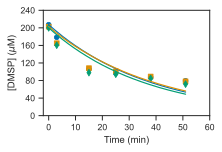

In [54]:
# Group by replicate
df_group = df_enzyme.groupby(['Replicate'])

# Define fig and axes
fig = plt.figure(figsize=(3, 1.95), dpi=192)
ax = fig.add_subplot(111)

# Define colors
colors = sns.color_palette('colorblind', n_colors=len(df_group))
# Define markers
markers = ['o', 's', 'd']

# Loop through replicate
for i, (group, data) in enumerate(df_group):
    # Extract initial concentration
    so = data.Real_conc.max()
    # Extract km
    Km = data.km.unique()
    # Extract fit vmax
    vmax = df_fit_paramls[df_fit_paramls.replicate == group].vmax.values
    # Append experimental time points
    time_exp = data.Time_min
    time = np.sort(
        np.unique(
            np.append(time, time_exp)
        )
    )
    # Plot fit
    ax.plot(time, 
               substrate_kinetics(so, vmax, Km, time), c=colors[i])
    
    # Plot experimental data
    ax.scatter(data.Time_min, data.Real_conc, color=colors[i], marker=markers[i])
    #Set axes labels
    ax.set_ylabel(r'[DMSP] ($\mu$M)')
    ax.set_xlabel(r'Time (min)')
    #Set axes limits and tick marks
    ax.set_ylim(0,240)
    ax.set_yticks(arange(0,250,40)) 
    ax.set_xlim(-2,60)
    ax.set_xticks(arange(0,70,10))
#Save figure
fig.savefig(f'{homedir}/figures/data/DddP_rate.pdf', bbox_inches='tight')

#### Plot of the isotope data: Approximation to the $^{34}S$ of DMSP vs. -ln DMSP remaining, where the slope represents the enzyme fractionation factor

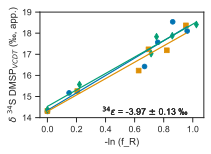

In [55]:
# Group by replicate
df_group = df_enzyme.groupby(['Replicate'])

# Define colors
colors = sns.color_palette('colorblind', n_colors=len(df_group))
# Define markers
markers = ['o', 's', 'd']

# Define fig and axes
fig = plt.figure(figsize=(2.95, 1.95), dpi=192)
ax = fig.add_subplot(111)

# Loop through replicates
for i, (group, data) in enumerate(df_group):
    #Calculate trendline  
    z = np.polyfit(data.minus_ln_f_R, data.d34S_approx_DMSP, 1)
    p = np.poly1d(z)
 
    # Plot fit
    ax.plot(data.minus_ln_f_R, p(data.minus_ln_f_R), c=colors[i])
    
    # Plot experimental data
    ax.scatter(data.minus_ln_f_R, data.d34S_approx_DMSP, color=colors[i], marker=markers[i],
              label = group)
    #ax.set_title('DddY')
    ax.set_xlabel('-ln (f_R)')
    ax.set_ylabel('$\delta$ ${}^{34}$S DMSP$_{VCDT}$ (‰, app.)')
    ax.set_ylim(14,19,1)
    #Add epsilon (fractionation factor)
    ax.text(0.9, 0.01, '$^{34}$$\epsilon$ = %s $\pm$ %s ‰' 
            %(-df_100_stats.loc[0,"slope"], df_100_stats.loc[1,"slope"]),
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes, fontsize=9)
    
fig.savefig(f'{homedir}/figures/data/DddP_fr_reactant.pdf', bbox_inches='tight')

#### Plot of the isotope data: Approximation to the $^{34}S$ of DMSP vs. time

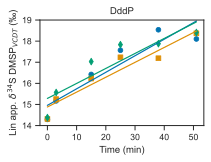

In [56]:
# Group by replicate
df_group = df_enzyme.groupby(['Replicate'])

# Define colors
colors = sns.color_palette('colorblind', n_colors=len(df_group))
# Define markers
markers = ['o', 's', 'd']

# Define fig and axes
fig = plt.figure(figsize=(2.95, 1.95), dpi=192)
ax = fig.add_subplot(111)

# Loop through replicates
for i, (group, data) in enumerate(df_group):
    #Calculate trendline  
    z = np.polyfit(data.Time_min, data.d34S_approx_DMSP, 1)
    p = np.poly1d(z)
 
    # Plot fit
    ax.plot(data.Time_min, p(data.Time_min), c=colors[i])
    
    # Plot experimental data
    ax.scatter(data.Time_min, data.d34S_approx_DMSP, color=colors[i], marker=markers[i],
              label = group)
    ax.set_title('DddP')
    ax.set_xlabel('Time (min)')
    ax.set_ylabel('Lin app. $\delta ^{34}$S DMSP$_{VCDT}$ (‰)')
    ax.set_ylim(14,19,1)

    
fig.savefig(f'{homedir}/figures/data/DddP_fr_time.pdf', bbox_inches='tight')

Since the linear fit is not good, we proceeded to perform experiments to determine if this was due to a potential loss of enzyme activity over time.